In [1]:
import torch
import torch.nn.functional as F
import random
from collections import deque
import gym
import numpy as np
import torch.autograd
from torch.autograd import Variable
import sys
import matplotlib.pyplot as plt

In [2]:
class critic(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(critic,self).__init__()
        self.linear1=torch.nn.Linear(input_size,hidden_size)
        self.linear2=torch.nn.Linear(hidden_size,hidden_size)
        self.linear3=torch.nn.Linear(hidden_size,output_size)
        
    def forward(self,state,action):
        x=torch.cat([state,action],1)
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=self.linear3(x)
        return x
        

In [3]:
class actor(torch.nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(actor,self).__init__()
        self.linear1=torch.nn.Linear(input_size,hidden_size)
        self.linear2=torch.nn.Linear(hidden_size,hidden_size)
        self.linear3=torch.nn.Linear(hidden_size,output_size)
        
    def forward(self,state):
        x=F.relu(self.linear1(state))
        x=F.relu(self.linear2(x))
        x=torch.tanh(self.linear3(x))
        return x

In [4]:
class memory():
    def __init__(self,max_size):
        self.buffer=deque(maxlen=max_size)
    def push(self,state,action,reward,next_state,done):
        experience=(state,action,np.array([reward]),next_state,done)
        self.buffer.append(experience)
    def sample(self,batch_size):
        state_batch=[]
        action_batch=[]
        reward_batch=[]
        next_state_batch=[]
        done_batch=[]
        batch=random.sample(self.buffer,batch_size)
        for experience in batch:
            state,action,reward,next_state,done=experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        return state_batch,action_batch,reward_batch,next_state_batch,done_batch
    def __len__(self):
        return len(self.buffer)

In [5]:
class NormalizedEnv(gym.ActionWrapper):
     def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

     def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

In [6]:
class OUnoise(object):
    def __init__(self,action_space,mu=0.0,theta=1.5,max_sigma=0.3,min_sigma=0.3,decay_period=100000):
        self.mu=mu
        self.theta=theta
        self.sigma=max_sigma
        self.max_sigma=max_sigma
        self.min_sigma=min_sigma
        self.decay_period=decay_period
        self.action_dim=action_space.shape[0]
        self.low=action_space.low
        self.high=action_space.high
        self.reset()
    def reset(self):
        self.state=np.ones(self.action_dim)*self.mu
    def evolve_state(self):
        x=self.state
        dx=self.theta*(self.mu-x)+self.sigma*np.random.randn(self.action_dim)
        self.state=x+dx
        return self.state
    def get_action(self,action,t=0):
        ou_state=self.evolve_state()
        self.sigma=self.max_sigma-(self.max_sigma-self.min_sigma)*min(1.0,t/self.decay_period)
        return np.clip(action+ou_state,self.low,self.high)

In [7]:
class DDPGagent(object):
    def __init__(self,env,hidden_size=256,actor_lr=1e-3,critic_lr=1e-4,gamma=0.99,tau=1e-2,max_memory_size=50000):
        self.num_states=env.observation_space.shape[0]
        self.num_actions=env.action_space.shape[0]
        self.gamma=gamma
        self.tau=tau
        self.actor=actor(self.num_states,hidden_size,self.num_actions)
        self.actor_target=actor(self.num_states,hidden_size,self.num_actions)
        self.critic=critic(self.num_states+self.num_actions,hidden_size,1)
        self.critic_target=critic(self.num_states+self.num_actions,hidden_size,1)
        for para,target_para in zip(self.actor.parameters(),self.actor_target.parameters()):
            target_para.data.copy_(para.data)
        for para,target_para in zip(self.critic.parameters(),self.critic_target.parameters()):
            target_para.data.copy_(para.data)
        self.memory=memory(max_memory_size)
        self.critic_criterion=torch.nn.MSELoss()
        self.actor_optimizer=torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer=torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
    def get_action(self,state):
        state=Variable(torch.from_numpy(state).float().unsqueeze(0))
        action=self.actor.forward(state)
        action=action.detach().numpy()[0,0]
        return action
    def update(self,batch_size):
        states,actions,rewards,next_states,done=self.memory.sample(batch_size)
        states=torch.FloatTensor(states)
        actions=torch.FloatTensor(actions)
        next_states=torch.FloatTensor(next_states)
        rewards=torch.FloatTensor(rewards)
        Qvals=self.critic.forward(states,actions)
        next_actions=self.actor_target.forward(states)
        next_Qvals=self.critic_target(next_states,next_actions.detach())
        Q_prime=rewards+self.gamma*next_Qvals
        critic_loss=self.critic_criterion(Qvals,Q_prime)
        policy_loss=-self.critic.forward(states,self.actor.forward(states)).mean()
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        for para,target_para in zip(self.actor.parameters(),self.actor_target.parameters()):
            target_para.data.copy_(para.data*self.tau+target_para*(1-self.tau))
        for para,target_para in zip(self.critic.parameters(),self.critic_target.parameters()):
            target_para.data.copy_(para.data*self.tau+target_para*(1-self.tau))

In [12]:
env = gym.make("Pendulum-v0")

agent = DDPGagent(env)
noise = OUnoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

In [13]:
env.action_space

Box(1,)

In [10]:
for episode in range(50):
    state=env.reset()
    noise.reset()
    episode_reward=0
    for step in range(500):
        action=agent.get_action(state)
        action=noise.get_action(action)
        new_state,reward,done,_=env.step(action)
        agent.memory.push(state,action,reward,new_state,done)
        if len(agent.memory)>batch_size:
            agent.update(batch_size)
        state=new_state
        episode_reward+=reward
        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break
    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

C:\Users\MATDY\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\MATDY\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


episode: 0, reward: -1524.43, average _reward: nan 
episode: 1, reward: -1444.87, average _reward: -1524.4257740424766 
episode: 2, reward: -1727.12, average _reward: -1484.649480138666 
episode: 3, reward: -1738.79, average _reward: -1565.472024078551 
episode: 4, reward: -1809.7, average _reward: -1608.801149218844 
episode: 5, reward: -1737.51, average _reward: -1648.981639810338 
episode: 6, reward: -1704.45, average _reward: -1663.7358661088174 
episode: 7, reward: -1249.13, average _reward: -1669.5519782379854 
episode: 8, reward: -1657.62, average _reward: -1616.9997120799471 
episode: 9, reward: -1423.61, average _reward: -1621.512578630559 
episode: 10, reward: -1490.88, average _reward: -1601.7227532733136 
episode: 11, reward: -1342.46, average _reward: -1598.3681623307316 
episode: 12, reward: -1376.2, average _reward: -1588.1268426510592 
episode: 13, reward: -1192.85, average _reward: -1553.035086846106 
episode: 14, reward: -1384.68, average _reward: -1498.440934821814 


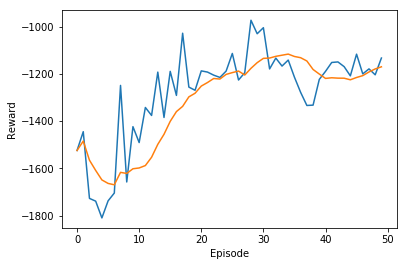

In [11]:
plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()